A typical interstellar medium hydrogen number density is $n_H = 10^6\,\mathrm{m}^{-3}$, and a typical temperature is $T = 104\,\mathrm{K}$.

To solve the ionisation equations, we need to determine the ionisation fraction $x = n_p / n_H$ at each step as we move away from the star. The neutral hydrogen density is then $n_{H^0} = n_H(1 - x)$. From the previous derivations, the ionisation balance at any distance $r$ is
\begin{equation}
    \frac{x^2}{1-x} = \frac{\Gamma(r, \tau_{\nu_0})}{n_H \alpha_B},
\end{equation}
where $\Gamma$ is the photoionisation rate per atom
\begin{equation}
    \Gamma(r, \tau_{\nu_0}) = \frac{1}{4\pi r^2} \int_{\nu_0}^{\infty} \frac{L_\nu}{h\nu} a_{\nu_0} \left( \frac{\nu_0}{\nu} \right)^3 e^{-\tau_{\nu_0} (\nu_0/\nu)^3} \,d\nu.
\end{equation}

The algorithm works as follows:

1.  Initialise Parameters:
    *   Set physical constants ($\hbar, c, k, \sigma, a_{\nu_0}, \nu_0$).
    *   Set ISM parameters ($n_H = 10^6, T_{gas} = 10^4 \to \alpha_B$).
    *   Set star parameters ($R_*, T_*$).
    *   Set initial conditions: $r = R_*$ and $\tau_{\nu_0} = 0$.

2.  Coordinate Loop:

    Iterate in $r$ until the gas becomes neutral.
    
    *   Step A: Calculate ionisation rate $\Gamma$:

        Compute the integral for the current optical depth $\tau_{\nu_0}$. This requires numerical integration over frequency $\nu$ from $\nu_0$ to a sufficiently high frequency where flux is negligible.
        
    *   Step B: Solve for ionisation fraction $x$:

        Let $F = \frac{\Gamma}{n_H \alpha_B}$. The balance equation is $x^2 = F(1-x)$. Rearrange into a standard quadratic equation

        \begin{equation}
            x^2 + Fx - F = 0.
        \end{equation}
        which has the positive root
        \begin{equation}
            x = \frac{-F + \sqrt{F^2 + 4F}}{2}.
        \end{equation}
        
    *   Step C: Store results $r, n_p = x n_H, n_{H^0} = (1-x)n_H$.

    *   Step D: Update optical depth:

        Calculate the change in optical depth over the step size $dr$,

        \begin{equation}
            d\tau_{\nu_0} = n_{H^0}(r) a_{\nu_0} dr = n_H(1-x) a_{\nu_0} \,dr.
        \end{equation}

        Update the state $\tau_{\nu_0} \leftarrow \tau_{\nu_0} + d\tau_{\nu_0}$ and update the position: $r \leftarrow r + dr$.

The coefficients involve large powers of $10$. Direct calculation can lead to floating-point underflow or overflow.

Instead of integrating over frequency $\nu$, we use the dimensionless variable$ u = \frac{h\nu}{kT_*}$. Consequently, $\nu = \frac{kT_*}{h}u$ and $d\nu = \frac{kT_*}{h}\,du$. The exponential term in the black-body function becomes $e^u$. The distance $r$ is also very large, so similarly, we to normalise $r$ by the star's radius $R_*$ or the Stroemgren radius $R_S$, where $\xi = r / R_S$.

When solving the quadratic equation, if the star is very bright, $F$ can be huge, making $x \approx 1$. Calculating $1-x$ directly might result in precision loss, so it is better to solve directly for the neutral fraction $y = 1-x$ in the limit of high ionisation.

---

The structure consists of a vast, nearly empty interior where the gas is almost entirely ionised $n_{H^0} \approx 0$, followed by a very thin ionisation front where the gas abruptly transitions to neutral.  If we integrate in $dr$, then:

*   Inside the sphere, $n_{H^0}$ is very small, so $\frac{d\tau}{dr} \propto n_{H^0}$ is nearly zero. We waste computational time integrating over huge distances where nothing changes.

*   At the edge, $n_{H^0}$ shoots up to $n_H$. The derivative $\frac{d\tau}{dr}$ becomes massive. To resolve this sharp wall, a fixed step size $dr$ would need to be incredibly small, or the simulation loses accuracy.

If we invert the differential equation, then
\begin{equation}
    \frac{dr}{d\tau_{\nu_0}} = \frac{1}{n_H (1-x) a_{\nu_0}}.
\end{equation}
We now step in increments of optical depth $d\tau$ and use an adaptive step-size:

*   Inside the sphere at $x \approx 1$, the term $(1-x)$ is small, making $\frac{dr}{d\tau}$ huge. A small step in $\tau$ corresponds to a large jump in distance $r$. This allows the program to jump across the quiet interior.

*   At the edge of the sphere at $x \to 0$, the term $(1-x)$ approaches $1$, making $\frac{dr}{d\tau}$ small. We slow down in $r$-space, placing many data points exactly where the ionisation front is located.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Constants
h = 6.626e-34       # Planck's constant
c = 3.0e8           # Speed of light
k_B = 1.38e-23      # Boltzmann's constant
nu_0 = 3.29e15      # Threshold freq
a_0 = 6.3e-22       # Cross-section at threshold
pc = 3.086e16       # Parsec in meters
n_H = 1e6

class StromgrenSolver:
    def __init__(self, R_star, T_star, n_H, T_gas):
        self.R_star = R_star
        self.T_star = T_star
        self.n_H = n_H

        # Interpolate recombination coefficient alpha_B
        temps = np.array([5000, 10000, 20000])
        alphas = np.array([4.54e-19, 2.59e-19, 2.52e-19])

        if T_gas <= 5000: self.alpha_B = 4.54e-19
        elif T_gas >= 20000: self.alpha_B = 2.52e-19
        else:
            f = interp1d(temps, alphas)
            self.alpha_B = float(f(T_gas))

    def _blackbody_flux(self, nu):
        # Planck function B_nu * pi
        exp_arg = (h * nu) / (k_B * self.T_star)
        exp_arg = np.clip(exp_arg, 1e-10, 700)
        term = np.expm1(exp_arg)
        return (2 * np.pi * h * nu**3) / (c**2 * term)

    def get_equilibrium_x(self, r, tau_current, nus, dnu, integrand_base):
        # Calculate photoionisation rate at current r and tau
        tau_nu = tau_current * (nu_0 / nus)**3
        attenuation = np.exp(-tau_nu)

        integral = np.sum(integrand_base * attenuation) * dnu
        Gamma = integral * (self.R_star / r)**2

        RHS = Gamma / (self.n_H * self.alpha_B)

        if RHS < 1e-10: return 0.0
        if RHS > 1e10: return 1.0

        x = (-RHS + np.sqrt(RHS**2 + 4*RHS)) / 2.0
        return max(0.0, min(1.0, x))

    def solve(self, max_steps=2000):
        # Frequency grid
        nu_max = max(15 * k_B * self.T_star / h, 2 * nu_0)
        nus = np.linspace(nu_0, nu_max, 100)
        dnu = nus[1] - nus[0]

        # Pre-calculate base integral terms
        sigma_nu = a_0 * (nu_0 / nus)**3
        flux_surface = self._blackbody_flux(nus)
        integrand_base = (flux_surface / (h * nus)) * sigma_nu

        # Initial conditions
        r = self.R_star
        tau = 0.0

        r_list = []
        x_list = []

        # Main Loop
        for i in range(max_steps):
            # Solve for current ionisation fraction x
            x = self.get_equilibrium_x(r, tau, nus, dnu, integrand_base)

            r_list.append(r)
            x_list.append(x)

            # Stop if neutral
            if x < 0.01: break

            # Determine step size dr
            neutral_density = self.n_H * (1.0 - x)

            if neutral_density < 1e-12:
                # If gas is empty of neutral atoms, dtau/dr is 0.
                dr = 0.05 * r
            else:
                # Calculate physical step for dtau = 0.1
                dr_optical = 0.1 / (neutral_density * a_0)
                dr = min(dr_optical, 0.05 * r)

            # Update state
            # Add optical depth for this step and use average neutral density
            dtau_step = neutral_density * a_0 * dr

            tau += dtau_step
            r += dr

        return np.array(r_list), np.array(x_list)

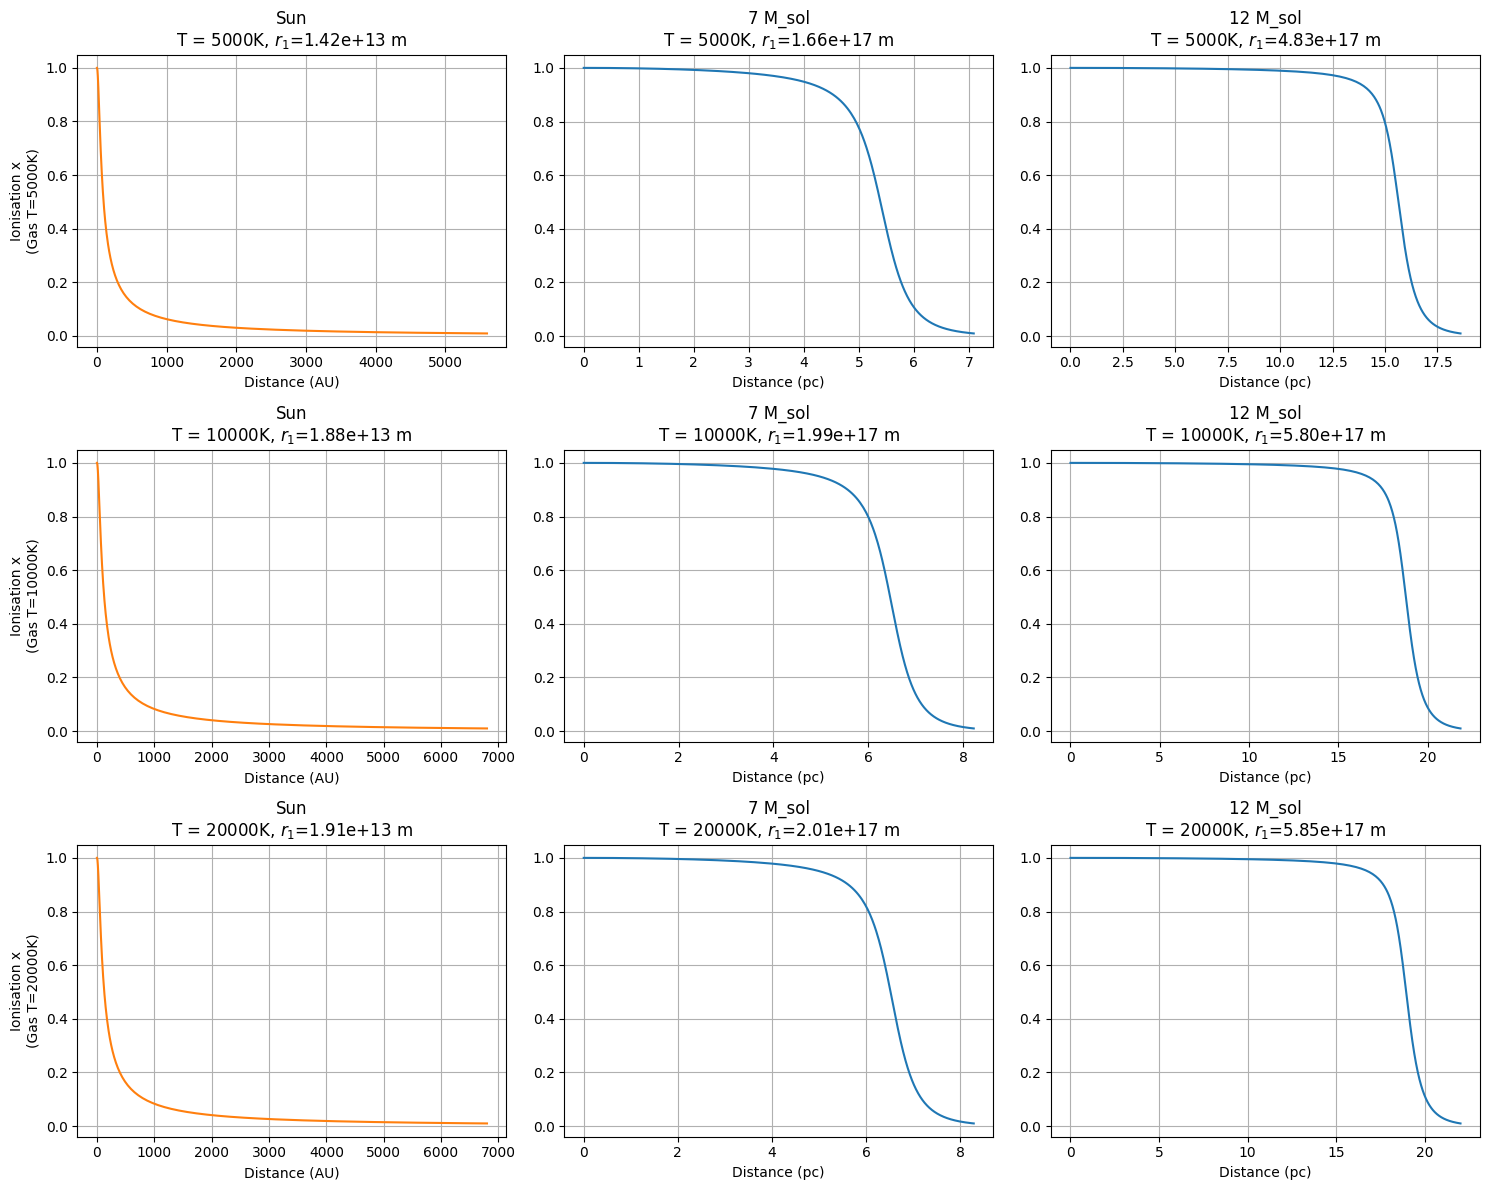

Star       | Gas T  | r1 (m)   | r1 (pc) 
---------------------------------------------
Sun        | 5000   | 1.42e+13 | 4.60e-04
Sun        | 10000  | 1.88e+13 | 6.09e-04
Sun        | 20000  | 1.91e+13 | 6.18e-04
7 M_sol    | 5000   | 1.66e+17 | 5.39e+00
7 M_sol    | 10000  | 1.99e+17 | 6.46e+00
7 M_sol    | 20000  | 2.01e+17 | 6.52e+00
12 M_sol   | 5000   | 4.83e+17 | 1.56e+01
12 M_sol   | 10000  | 5.80e+17 | 1.88e+01
12 M_sol   | 20000  | 5.85e+17 | 1.90e+01


In [22]:
stars = [
    {"name": "Sun",         "M": "1 M_sol",     "T": 5800,      "R": 6.96e8},
    {"name": "7 M_sol",     "M": "7 M_sol",     "T": 20000,     "R": 1.87e9},
    {"name": "12 M_sol",    "M": "12 M_sol",    "T": 25000,     "R": 3.79e9}
]

gas_temps = [5000, 10000, 20000]
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
results_store = []

for i, star in enumerate(stars):
    for j, T_gas in enumerate(gas_temps):
        solver = StromgrenSolver(star["R"], star["T"], n_H, T_gas)
        r, x = solver.solve()

        # Calculate r1
        if np.all(x > 0.5): r1 = r[-1] # Shouldn't happen
        elif np.all(x < 0.5): r1 = r[0]
        else:
            f = interp1d(x[::-1], r[::-1]) # Invert for interpolation
            r1 = float(f(0.5))

        results_store.append((star['name'], T_gas, r1))

        ax = axes[j, i] # Rows = Gas Temp, Cols = Star Mass

        # Normalise x-axis to r1 to show the shape similarity
        if star["name"] == "Sun":
            # Sun is tiny, plotting in parsecs will look like a vertical line at 0
            ax.plot(r / 1.5e11, x, color='tab:orange')
            ax.set_xlabel('Distance (AU)')
        else:
            ax.plot(r / pc, x, color='tab:blue')
            ax.set_xlabel('Distance (pc)')

        ax.set_title(f"{star['name']}\nT = {T_gas}K, $r_1$={r1:.2e} m")
        ax.grid(True)
        if i == 0: ax.set_ylabel(f'Ionisation x\n(Gas T={T_gas}K)')

plt.tight_layout()
plt.show()

print(f"{'Star':<10} | {'Gas T':<6} | {'r1 (m)':<8} | {'r1 (pc)':<8}")
print("-" * 45)
for res in results_store:
    print(f"{res[0]:<10} | {res[1]:<6} | {res[2]:.2e} | {res[2]/pc:.2e}")

There is a distinct plateau where the gas is almost $100\%$ ionised when $x \approx 1$, followed by a very sharp drop to neutrality when $x \approx 0$ at the ionisation front.

*   Massive stars generate large classical Stroemgren spheres. The UV output of a slar scales exponentially with temperature in this range, so a small increase in stellar temperature leads to a massive increase in ionising photons.
*   The Sun's behaviour is fundamentally different. The ionisation fraction drops off immediately. This is because the Sun's surface temperature is too low to produce a significant flux of ionising UV photons. The sphere is microscopic, comparable to the size of the solar system.

For all stars, increasing the gas temperature increases the size of the ionized region $r_1$. This occurs because the recombination coefficient $\alpha_B$ decreases as the gas gets hotter (electrons moving faster are harder for protons to capture). With a lower recombination rate, the same number of photons from the star can keep a larger volume of gas ionised. Theory predicts that the Stroemgren radius scales with the recombination coefficient as $R_S \propto \alpha_B^{-1/3}$.

---

We can integrate over volume from $r = 0$ to $r = \infty$ by using the definition of $\tau_\nu$ to replace $dr$ and assuming that the recombination term is well approximated by $n_p = n_e = n_H$ for $r \leq r_1$ (gas is fully ionised) and $n_p = n_e = 0$ for $r > r_1$ (gas is neutral). This $r_1$ is called the Stroemgren radius.

We start with the principle of ionisation equilibrium: The total number of ionisations per second in the entire volume must equal the total number of recombinations per second. We integrate the recombination rate per unit volume $n_p n_e \alpha_B$ over the entire volume of the sphere. Since $n_H$ and $\alpha_B$ are constant,
\begin{align}
    \text{Total Recombinations}
    &= \int_{0}^{\infty} (n_p n_e \alpha_B) \, 4\pi r^2 \, dr \\
    &= \int_{0}^{r_1} (n_H^2 \alpha_B) \, 4\pi r^2 \, dr \\
    &= 4\pi n_H^2 \alpha_B \left[ \frac{r^3}{3} \right]_0^{r_1} \\
    &= \frac{4\pi}{3} r_1^3 n_H^2 \alpha_B.
\end{align}
The ionisation rate per unit volume at radius $r$ is
\begin{equation}
    n_{H^0} \int \frac{L_\nu}{4\pi r^2 h \nu} a_\nu e^{-\tau_\nu} d\nu.
\end{equation}
Integrating this over volume $4\pi r^2 dr$ gives the total ionisations (swapping the order of integration),
\begin{align}
    \text{Total Ionisations}
    &= \int_{0}^{\infty} \left( n_{H^0}(r) \int_{\nu_0}^{\infty} \frac{L_\nu}{4\pi r^2 h \nu} a_\nu e^{-\tau_\nu} \,d\nu \right) 4\pi r^2 \, dr\\
    &= \int_{0}^{\infty} n_{H^0}(r) \int_{\nu_0}^{\infty} \frac{L_\nu}{h \nu} a_\nu e^{-\tau_\nu} \, d\nu \, dr \\
    &= \int_{\nu_0}^{\infty} \frac{L_\nu}{h \nu} \left( \int_{0}^{\infty} n_{H^0}(r) a_\nu e^{-\tau_\nu} \, dr \right) \,d\nu \\
    &= \int_{\nu_0}^{\infty} \frac{L_\nu}{h \nu} \left( \int_{0}^{\infty} e^{-\tau_\nu} \, d\tau_\nu \right) \,d\nu \\
    &= \int_{\nu_0}^{\infty} \frac{L_\nu}{h \nu} \left[ -e^{-\tau_\nu} \right]_0^{\infty} \,d\nu \\
    &= \int_{\nu_0}^{\infty} \frac{L_\nu}{h \nu} \, d\nu.
\end{align}
Equating the two sides, we obtain
\begin{equation}
    Q(H) := \frac{4\pi}{3} r_1^3 n_H^2 \alpha_B.
\end{equation}

For the massive stars, the analytical and numerical values for $r_1$ are very close. These stars emit so much UV radiation that the gas surrounding them is almost $100\%$ ionised $x \approx 1$, right up to the edge. In the numerical simulation, we see the transition region at the edge where the ionisation drops. In this region, the recombination rate ($n_e n_p \alpha$) is lower than the maximum assumed in the analytical model. Since the gas is recombining less efficiently at the edge, the photons can penetrate slightly further, making the numerical radius larger.

For the Sun, there is a significant discrepancy. The analytical formula predicts a much larger radius than the numerical simulation. The Stroemgren sphere approximation relies on the assumption that the gas is fully ionised $n_{neutral} \approx 0$ inside the sphere. The Sun's ionising flux is relatively weak so the approximation breaks down. Once $x$ drops even slightly, the density of neutral hydrogen ($n_{neutral}$) becomes significant. This causes the optical depth $\tau$ to increase significantly, absorbing the remaining photons rapidly.